**Variational Autoencoder using MNIST**

In this code, we are going to implement step-by-step a Variational AutoEncoder on the MNIST dataset. If you have any questions, you can contact the instructor. The code needs GPU to run at an acceptable rate: if you are in Colab, go to Menu > Runtime > Change runtime type and select GPU as Hardware accelerator. If you are running this code locally, make sure you have a GPU and the necessary libraries installed.

The first thing we need to do is to import the necessary libraries. We will use numpy, matplotlib, torch, tqdm and torchvision to load the dataset. We will also use the magic command `%matplotlib inline` to show the plots in the notebook. Note that we also seed the code for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.datasets as datasets
%matplotlib inline

# Seed the code for reproducibility
rng = np.random.default_rng(1234)
_ = torch.manual_seed(1234)

Implement the Variational Autoencoder: remember that in the latent space, we need to implement the reparameterization trick, which in this case is given by the following equation:

$z = \mu + \sigma \cdot \epsilon$

where $\mu$ and $\sigma$ are the mean and standard deviation of the latent space (given by the encoder), and $\epsilon$ is a random variable sampled from a standard normal distribution. The decoder is a simple neural network that takes as input the latent space and outputs the reconstructed image. The encoder is a simple neural network that takes as input the image and outputs the mean and standard deviation of the latent space. Note that we use a sigmoid activation function in the last layer of the decoder, as we want the output to be in the $[0, 1]$ range.

Regarding the losses, remember that there are two terms:
* The reconstruction loss: we use a binary cross-entropy loss function for this term, as we are dealing with binary images.
* The KL loss: we use the analytical formula for the KL loss between a standard Gaussian and a multivariate, independent Gaussian with vector mean components $\mu_i$ and a diagonal covariance with entries $\sigma_i$, which is: $KL = -0.5 \sum_{i=1}^d (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$, where $d$ is the dimension of the latent space, $\mu_i$ is the mean of the $i$-th dimension of the latent space, and $\sigma_i$ is the standard deviation of the $i$-th dimension of the latent space.

In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 16),
            nn.ReLU(),
        )
        self.z_mean = nn.Linear(16, latent_dim)
        self.z_log_var = nn.Linear(16, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 7 * 7 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            print('Using GPU: ' + torch.cuda.get_device_name(0))
            self.cuda()
        else:
            print('Using CPU: note that the code may be slow')

    def encode(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x = self.encoder(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        eps = torch.randn_like(z_mean).to(self.device)
        return z_mean + torch.exp(z_log_var / 2) * eps

    def decode(self, z):
        return torch.squeeze(self.decoder(z))

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        return self.decode(z), z_mean, z_log_var

    def fit(self, X_train, X_val, epochs=50, batch_size=2048):  # Method to train the AE
        optimizer = torch.optim.Adam(self.parameters())  # Adam optimizer
        train_losses = []  # List to store the training loss
        val_losses = []  # List to store the validation loss

        self.encoder.to(self.device)
        self.decoder.to(self.device)
        X_train = X_train.to(self.device)
        X_val = X_val.to(self.device)

        for epoch in tqdm(range(epochs)):  # Loop over the epochs
            epoch_tr_loss = []  # List to store the loss of each batch
            for i in range(0, X_train.shape[0], batch_size):  # Loop over the batches
                x = X_train[i:i + batch_size] # Get the batch
                x_rec, z_mean, z_log_var = self.forward(x)  # Forward pass
                kl_loss = torch.mean(-0.5 * (1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var)))  # This is the KL loss (analytical for Gaussians!)
                rec_loss = nn.functional.binary_cross_entropy(x_rec, x, reduction='none')  # This is the reconstruction loss
                rec_loss = torch.mean(torch.sum(rec_loss, axis=(1,2)))  # Careful here: rec_loss is batch_size x 28 x 28: the average is on the bath dimension!
                loss = rec_loss + kl_loss  # Total loss
                optimizer.zero_grad()  # Zero the gradients
                loss.backward()  # Backpropagation
                optimizer.step()  # Update the weights
                epoch_tr_loss.append(loss.item())  # Append the loss to the list
            train_losses.append(np.mean(epoch_tr_loss))  # Append the average loss of the epoch to the list

            with torch.no_grad():  # We don't need gradients for validation
                x = X_val  # Get the validation data
                x_rec, z_mean, z_log_var = self.forward(x)  # Forward pass
                kl_loss = torch.mean(-0.5 * (1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var)))  # This is the KL loss (analytical for Gaussians!)
                rec_loss = nn.functional.binary_cross_entropy(x_rec, x, reduction='none')  # This is the reconstruction loss
                rec_loss = torch.mean(torch.sum(rec_loss, axis=(1,2)))  # Careful here: rec_loss is batch_size x 28 x 28: the average is on the bath dimension!
                loss = rec_loss + kl_loss  # Total loss
                val_losses.append(loss.item())  # Append the loss to the list

        return train_losses, val_losses  # Return the losses

Now, we are going to load the MNIST dataset. We will use the `datasets` module from `torchvision` to load the dataset. We will also convert normalize the images to be in the [0, 1] range.

In [3]:
# Load MNIST data
mnist_tr_set = datasets.MNIST(root='./D_set', train=True, download=True, transform=None)  # Training set
mnist_ts_set = datasets.MNIST(root='./D_set', train=False, download=True, transform=None)  # Test set
train_data = mnist_tr_set.data.float() / 255  # Convert images to be in [0, 1] range
test_data = mnist_ts_set.data.float() / 255  # Convert images to be in [0, 1] range

We are ready to train the VAE. We will use 100 dimensions for the latent representation, and we will train the VAE for 50 epochs. We will use a batch size of 2048. Beware of using the GPU: otherwise, the code may take too long to run (on a Tesla T4, it runs in less than 1 minute).

In [4]:
dimension = 2  # Latent dimension to be used
print('Training VAE...')
model = VAE(latent_dim=dimension)
train_loss, val_loss = model.fit(train_data, test_data, epochs=50, batch_size=2048)

Training VAE...
Using GPU: Tesla T4


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


Let us plot the training and validation losses, to visualize the learning.

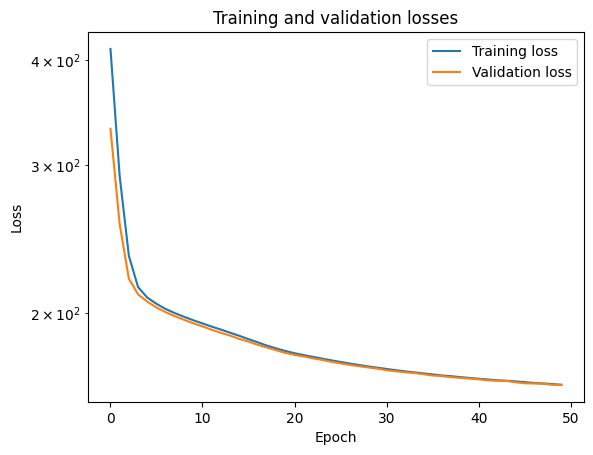

In [5]:
plt.semilogy(train_loss, label='Training loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

Finally, let us explore one of the characteristics of the VAE: the latent space is continous! We will sample the latent space using a linearly spaced grid, and we will plot the images generated by the decoder. Note that the latent space is 2-dimensional, so we will plot a 2D image.

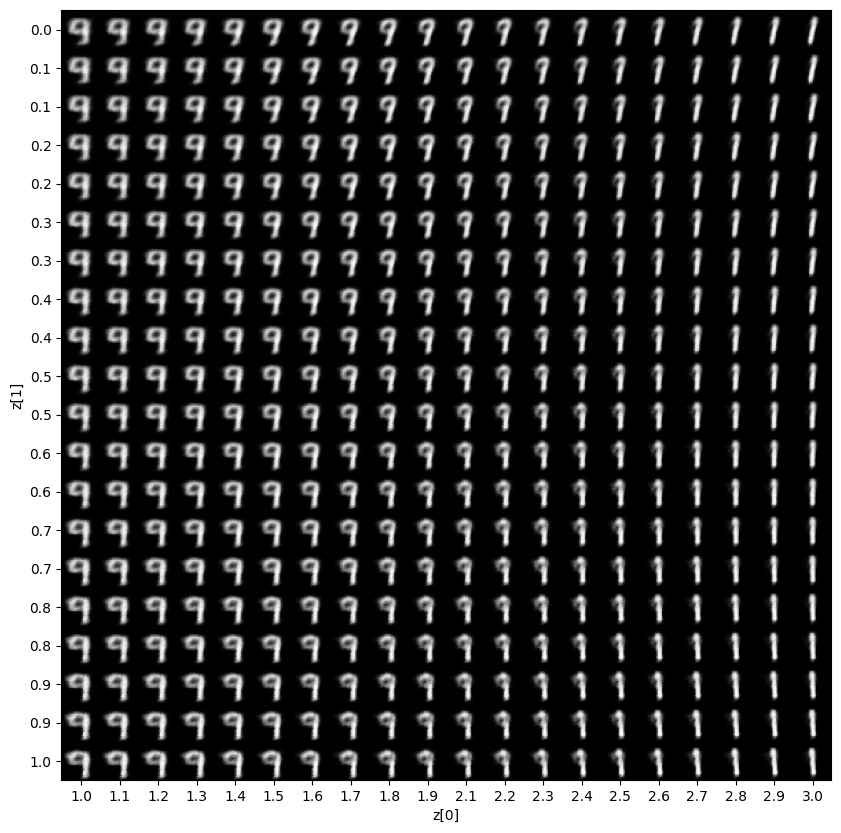

In [8]:
# Let us plot the latent space of the VAE: note that it is continuous!!
digit_size = 28
n = 20  # The total number of images generated is n ** 2: be careful as a too large n may be long to compute!

figure = np.zeros((digit_size * n, digit_size * n))  # Empty image to store each digit
# linearly spaced coordinates corresponding to the 2D plot of digit classes in the latent space: we sample the 2D latent space using a linearly spaced grid!
grid_x = np.linspace(1, 3, n)
grid_y = np.linspace(0, 1, n)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])  # Latent space sample is a point of the grid
        x_decoded = model.decode(torch.from_numpy(z_sample).float().to(model.device)).detach().cpu().numpy() # Image generated by the decoder
        figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = x_decoded  # Put the digit in the general image

# Now, plot the image of the latent space we just generated
figsize = 10
plt.figure(figsize=(figsize, figsize))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()

Let us now plot the latent space of the VAE, and color each point according to the digit class. Note that the latent space is continuous, but the digits are grouped together in the latent space. This is because the VAE is a generative model, and it tries to generate digits that are similar to the ones in the training set. Also, note how similar digits are close to each other in the latent space.

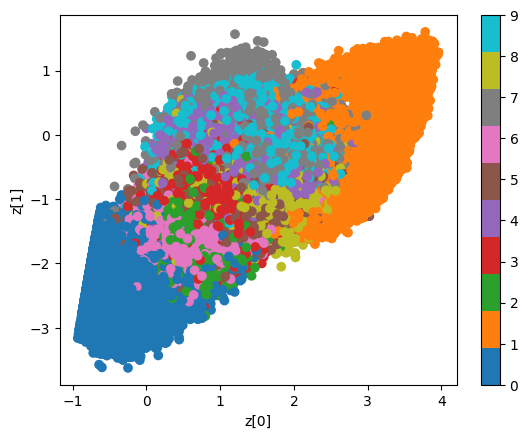

In [7]:
# display a 2D plot of the digit classes in the latent space
labels = mnist_tr_set.targets.numpy()
z_mean, _ = model.encode(train_data.to(model.device))
plt.scatter(z_mean[:, 0].detach().cpu().numpy(), z_mean[:, 1].detach().cpu().numpy(), c=labels, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()